!curl https://course.fast.ai/setup/colab | bash

pip install fastai

pip install fire

https://github.com/fastai/course-v3/blob/ca36c02484fec3bd3ed29dc137b26924b8fe4c3a/nbs/dl2/01_matmul.ipynb

In [1]:
#export
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [2]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

**Data prep**

In [3]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/Users/stanislavprihoda/.fastai/data/mnist.pkl.gz')

In [4]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [5]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [6]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [7]:
mpl.rcParams['image.cmap'] = 'gray'

In [8]:
img = x_train[0]

In [9]:
x_train.shape

torch.Size([50000, 784])

In [10]:
y_train.shape

torch.Size([50000])

In [11]:
x_valid.shape

torch.Size([10000, 784])

In [12]:
x_train[0].shape

torch.Size([784])

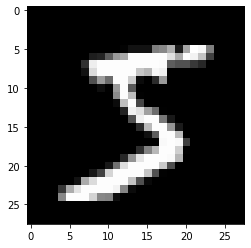

In [13]:
plt.imshow(img.view((28,28)))

**Model prep**

In [14]:
weights = torch.randn(784,10)

In [15]:
weights.shape

torch.Size([784, 10])

In [16]:
bias = torch.zeros(10)

In [17]:
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac==br
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      for k in range(ac):
        c[i,j]+=a[i,k]*b[k,j]
  return c

In [18]:
m1 = x_valid[:5]
m2 = weights

In [19]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [20]:
%timeit -n 10 t1 = matmul(m1,m2)

864 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
t1 = matmul(m1,m2)

**Elementwise ops**

In [22]:
a=tensor([10.,8,4])
b=tensor([11.,3,5])
a+b

tensor([21., 11.,  9.])

In [23]:
(a<b).float().mean()

tensor(0.6667)

In [24]:
m = tensor([[19.,30,12],[3,4,1],[32,3,1]]);m

tensor([[19., 30., 12.],
        [ 3.,  4.,  1.],
        [32.,  3.,  1.]])

In [25]:
(m*m).sum().sqrt()

tensor(49.6488)

In [26]:
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac==br
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      c[i,j]=(a[i,:]*b[:,j]).sum()
  return c

In [27]:
%timeit -n 10 _ = matmul(m1,m2)

1.52 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
808/1.32

612.1212121212121

In [29]:
#export
def near(a,b): return torch.allclose(a,b,rtol=1e-3,atol=1e-5)
def test_near(a,b): test(a,b,near)

In [30]:
test_near(t1,matmul(m1,m2))

**Broadcasting**

In [31]:
a

tensor([10.,  8.,  4.])

In [32]:
a>0

tensor([1, 1, 1], dtype=torch.uint8)

In [33]:
c=tensor([10.,20,30]);c

tensor([10., 20., 30.])

In [34]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [35]:
m+c

tensor([[29., 50., 42.],
        [13., 24., 31.],
        [42., 23., 31.]])

In [36]:
t=c.expand_as(m);t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [37]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [38]:
t.stride(),t.shape

((0, 1), torch.Size([3, 3]))

In [39]:
c

tensor([10., 20., 30.])

In [40]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [41]:
c.shape,c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [42]:
c.shape,c[None,:].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [43]:
c

tensor([10., 20., 30.])

In [44]:
c.expand_as(m)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [45]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [46]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [47]:
m+c[:,None].expand_as(m)

tensor([[29., 40., 22.],
        [23., 24., 21.],
        [62., 33., 31.]])

In [48]:
m

tensor([[19., 30., 12.],
        [ 3.,  4.,  1.],
        [32.,  3.,  1.]])

In [49]:
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac==br
  c = torch.zeros(ar,bc)
  for i in range(ar):
    # c[i,j]=(a[i,:]       *b[:,j]).sum()
    c[i] = (a[i].unsqueeze(-1)*b).sum(dim=0)
  return c

In [50]:
%timeit -n 10 _ = matmul(m1,m2)

327 µs ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
808000/351

2301.994301994302

**Broadcasting rules**

In [52]:
# proceeding axis
c[None,:].shape

torch.Size([1, 3])

In [53]:
# trailing axis
c[:,None].shape

torch.Size([3, 1])

In [54]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

**Einsum**

In [55]:
#c[i,j] += a[i,k]*b[k,j]
#einsum notation: ik,kj->ij
def matmul(a,b): torch.einsum('ik,kj->ij',a,b)

In [56]:
%timeit -n 10 _=matmul(m1,m2)

The slowest run took 10.42 times longer than the fastest. This could mean that an intermediate result is being cached.
133 µs ± 178 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
808000/90

8977.777777777777

**Pytorch**

In [58]:
%timeit -n 10 t2=m1.matmul(m2)

The slowest run took 7.46 times longer than the fastest. This could mean that an intermediate result is being cached.
28.1 µs ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
808000/23

35130.434782608696

In [60]:
%timeit -n 10 t2 = m1@m2

The slowest run took 6.77 times longer than the fastest. This could mean that an intermediate result is being cached.
27.4 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
t2 = m1@m2

In [62]:
test_near(t1,t2)

## Export

In [63]:
!python3 notebook2script.py 01_Matmul.ipynb

Converted 01_Matmul.ipynb to exp/nb_01.py
